# 📦 Stage 2: 商品・カテゴリ分析（ABC分析）

## 目的
**「どの商品が重要で、どの商品が不要か？」を明確にする**

このノートブックでは、ABC分析を使って商品を3つのランクに分類します：

### ABC分析とは？
- **A商品（重要商品）**: 売上の80%を占める商品 → 欠品厳禁、在庫確保
- **B商品（中堅商品）**: 売上の15%を占める商品 → 適正在庫を維持
- **C商品（補助商品）**: 売上の5%しかない商品 → 在庫圧縮、場合により廃番検討

### 分析内容
1. **商品別ABC分析**
   - 売上金額でランク付け
   - 売上数量でランク付け
   - 利益率（粗利）でランク付け

2. **カテゴリ別パフォーマンス**
   - 大分類・中分類・小分類の貢献度
   - 成長カテゴリと衰退カテゴリの特定

3. **死に筋商品の特定**
   - 売れない商品のリストアップ
   - 在庫削減候補の提案

4. **機会ロス商品の発見**
   - 売れているのに在庫が足りない商品
   - 発注強化が必要な商品

### 業務的な意義
- **発注担当**: A商品の欠品を防ぎ、C商品の過剰在庫を減らす
- **店長**: 売場配分・棚割りの優先順位を決める
- **オーナー**: 利益を最大化する商品構成を設計する

---

## 📦 1. 環境準備

In [ ]:
# 日本語フォント設定（共通モジュール）
import warnings
warnings.filterwarnings('ignore')

# よく使うライブラリを先に読み込む
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ウィジェットの有無を通知・フラグ化
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML, clear_output
    WIDGETS_AVAILABLE = True
    print('✅ ipywidgets利用可能')
except Exception:
    WIDGETS_AVAILABLE = False
    print('⚠️ ipywidgets未インストール - 一部機能制限')

import font_setup
JP_FP = font_setup.setup_fonts(show_test=False)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path

## 📁 2. データ読み込み

In [3]:
file_path = 'output/06_final_enriched_20250701_20250930.csv'

print(f"📂 データ読み込み中: {file_path}")
df = pd.read_csv(file_path, encoding='utf-8-sig')
df['日付'] = pd.to_datetime(df['日付'])

print(f"\n✅ 読み込み完了")
print(f"   データ期間: {df['日付'].min().strftime('%Y-%m-%d')} 〜 {df['日付'].max().strftime('%Y-%m-%d')}")
print(f"   総商品数: {df['商品名'].nunique():,}商品")
print(f"   総カテゴリ数: {df['フェイスくくり大分類'].nunique()}大分類")

📂 データ読み込み中: output/06_final_enriched_20250701_20250930.csv

✅ 読み込み完了
   データ期間: 2025-07-01 〜 2025-09-30
   総商品数: 1,864商品
   総カテゴリ数: 41大分類


## 📊 3. 商品別ABC分析（売上金額ベース）

### ABC分析の基本ルール
- **Aランク**: 累積売上構成比が0〜80%の商品
- **Bランク**: 累積売上構成比が80〜95%の商品
- **Cランク**: 累積売上構成比が95〜100%の商品

### 業務的な意味
- **A商品**: 全体の20%の商品が売上の80%を作る → 絶対に切らすな！
- **C商品**: 80%の商品が売上の5%しか作らない → 在庫削減のチャンス

In [4]:
# 商品別集計
product_summary = df.groupby('商品名').agg({
    '売上金額': 'sum',
    '売上数量': 'sum',
    '日付': 'nunique',
    '店舗': lambda x: x.nunique()
}).reset_index()

product_summary.columns = ['商品名', '売上金額', '売上数量', '販売日数', '取扱店舗数']

# ソート（売上金額降順）
product_summary = product_summary.sort_values('売上金額', ascending=False).reset_index(drop=True)

# 構成比・累積構成比の計算
product_summary['構成比'] = (product_summary['売上金額'] / product_summary['売上金額'].sum() * 100)
product_summary['累積構成比'] = product_summary['構成比'].cumsum()

# ABCランクの付与
def assign_abc_rank(cumulative_pct):
    if cumulative_pct <= 80:
        return 'A'
    elif cumulative_pct <= 95:
        return 'B'
    else:
        return 'C'

product_summary['ABCランク'] = product_summary['累積構成比'].apply(assign_abc_rank)

# 1日平均売上・平均単価
product_summary['1日平均売上'] = (product_summary['売上金額'] / product_summary['販売日数']).round(0)
product_summary['平均単価'] = (product_summary['売上金額'] / product_summary['売上数量']).round(0)

print("="*60)
print("📊 商品別ABC分析結果")
print("="*60)
print(f"\n総商品数: {len(product_summary):,}商品")
print(f"  Aランク: {(product_summary['ABCランク']=='A').sum():,}商品 ({(product_summary['ABCランク']=='A').sum()/len(product_summary)*100:.1f}%)")
print(f"  Bランク: {(product_summary['ABCランク']=='B').sum():,}商品 ({(product_summary['ABCランク']=='B').sum()/len(product_summary)*100:.1f}%)")
print(f"  Cランク: {(product_summary['ABCランク']=='C').sum():,}商品 ({(product_summary['ABCランク']=='C').sum()/len(product_summary)*100:.1f}%)")

print("\n" + "-"*60)
print("【Aランク商品（上位20商品）】")
print(product_summary[product_summary['ABCランク']=='A'].head(20)[['商品名', '売上金額', '構成比', '累積構成比', 'ABCランク']].to_string(index=False))

📊 商品別ABC分析結果

総商品数: 1,864商品
  Aランク: 372商品 (20.0%)
  Bランク: 449商品 (24.1%)
  Cランク: 1,043商品 (56.0%)

------------------------------------------------------------
【Aランク商品（上位20商品）】
                  商品名  売上金額   構成比  累積構成比 ABCランク
        テリアメンソール 1960992.0 2.358424    2.358424         A
    い・ろ・は・す５４０ 1190974.0 1.432347    3.790771         A
     ◎ジャスミン茶６００ 1180190.0 1.419378    5.210149         A
          直巻　焼しゃけ 1021944.0 1.229060    6.439209         A
             ◎緑茶６００ 1019700.0 1.226361    7.665570         A
          テリアＯパール  968880.0 1.165242    8.830812         A
直巻　和風ツナマヨネーズ  947640.0 1.139697    9.970509         A
手巻シーチキンマヨネーズ  880770.0 1.059275   11.029784         A
        鮭はらみおむすび  870492.0 1.046914   12.076697         A
    ３種のミックスサンド  823672.0 0.990605   13.067302         A
 ◎天然水新潟県津南６００  794970.0 0.956086   14.023387         A
          直巻　とり五目  692340.0 0.832656   14.856043         A
      健康ミネラルむぎ茶  668498.0 0.803982   15.660025         A
    ｉｎゼリーエネルギー  629370.0 0.756924 

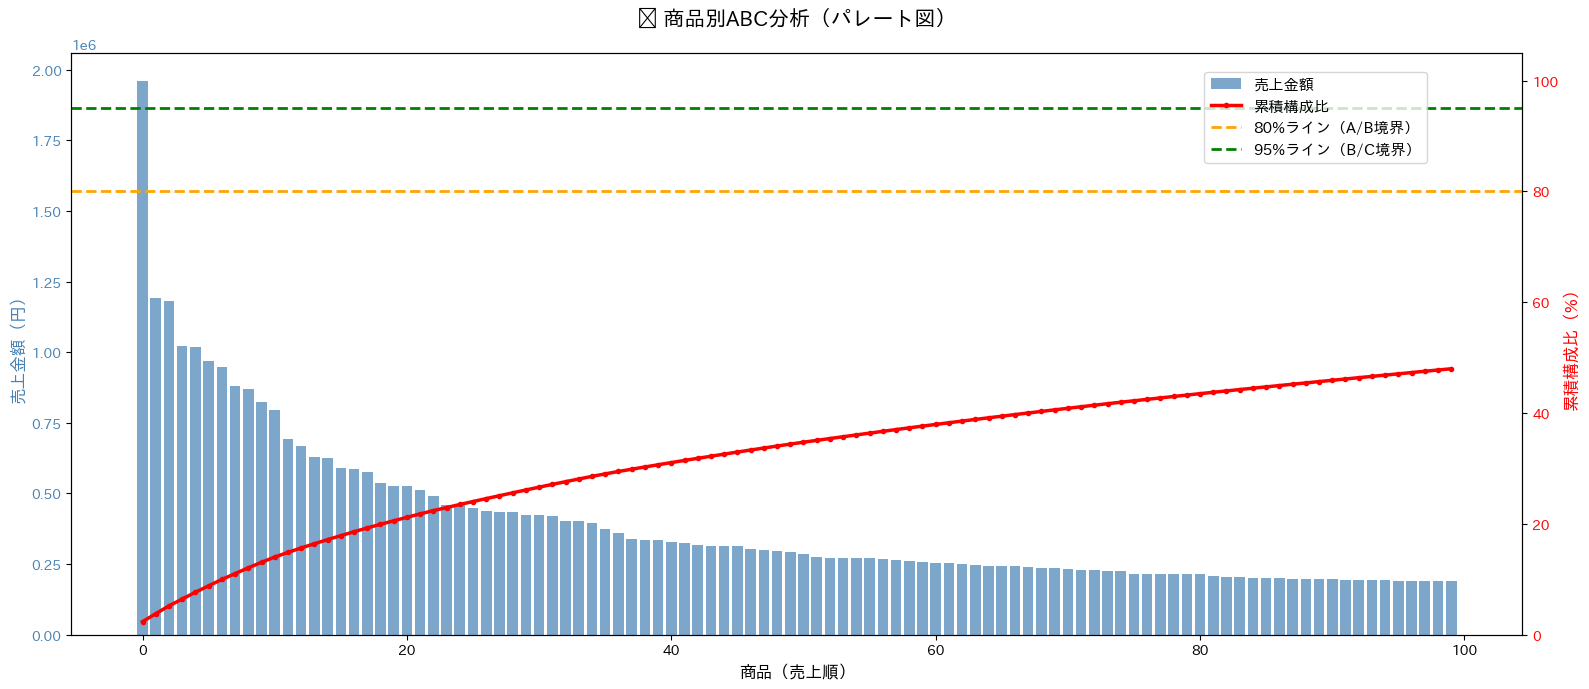


💡 パレート図の読み方
  ✓ 赤い線が急上昇する左側の商品 → A商品（重要！）
  ✓ 80%ラインに到達するまでの商品数 → A商品の個数
  ✓ 右側の平坦な部分の商品 → C商品（在庫削減候補）


In [5]:
# ABC分析グラフ（パレート図）
fig, ax1 = plt.subplots(figsize=(16, 7))

# 商品数を制限（上位100商品のみ表示）
top_products = product_summary.head(100)

# 棒グラフ（売上金額）
ax1.bar(range(len(top_products)), top_products['売上金額'], color='steelblue', alpha=0.7, label='売上金額')
ax1.set_xlabel('商品（売上順）', fontsize=12, fontproperties=JP_FP)
ax1.set_ylabel('売上金額（円）', fontsize=12, color='steelblue', fontproperties=JP_FP)
ax1.tick_params(axis='y', labelcolor='steelblue')

# 折れ線グラフ（累積構成比）
ax2 = ax1.twinx()
ax2.plot(range(len(top_products)), top_products['累積構成比'], color='red', linewidth=2.5, marker='o', markersize=3, label='累積構成比')
ax2.axhline(y=80, color='orange', linestyle='--', linewidth=2, label='80%ライン（A/B境界）')
ax2.axhline(y=95, color='green', linestyle='--', linewidth=2, label='95%ライン（B/C境界）')
ax2.set_ylabel('累積構成比（%）', fontsize=12, color='red', fontproperties=JP_FP)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 105)

# タイトル・凡例
ax1.set_title('📊 商品別ABC分析（パレート図）', fontsize=15, pad=20, fontproperties=JP_FP)
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9, prop=JP_FP), fontsize=11)

plt.tight_layout()
plt.show()

print("\n💡 パレート図の読み方")
print("  ✓ 赤い線が急上昇する左側の商品 → A商品（重要！）")
print("  ✓ 80%ラインに到達するまでの商品数 → A商品の個数")
print("  ✓ 右側の平坦な部分の商品 → C商品（在庫削減候補）")

## 🎯 4. ABCランク別の特徴分析

### 業務的な意義
各ランクの商品特性を理解し、適切な在庫管理・発注方針を決める

In [6]:
# ABCランク別集計
abc_summary = product_summary.groupby('ABCランク').agg({
    '商品名': 'count',
    '売上金額': 'sum',
    '売上数量': 'sum',
    '1日平均売上': 'mean'
}).round(0)

abc_summary.columns = ['商品数', '売上金額合計', '売上数量合計', '1日平均売上（平均）']
abc_summary['売上構成比'] = (abc_summary['売上金額合計'] / abc_summary['売上金額合計'].sum() * 100).round(1)
abc_summary['商品数構成比'] = (abc_summary['商品数'] / abc_summary['商品数'].sum() * 100).round(1)

# ランク順にソート
abc_summary = abc_summary.reindex(['A', 'B', 'C'])

print("="*60)
print("🎯 ABCランク別サマリー")
print("="*60)
print(abc_summary.to_string())

print("\n" + "-"*60)
print("【業務的な意味】")
print(f"  A商品: {abc_summary.loc['A', '商品数構成比']:.1f}%の商品が{abc_summary.loc['A', '売上構成比']:.1f}%の売上を作る")
print(f"  → A商品は絶対に欠品させない！ 発注・在庫確保を最優先")
print(f"\n  C商品: {abc_summary.loc['C', '商品数構成比']:.1f}%の商品が{abc_summary.loc['C', '売上構成比']:.1f}%の売上しか作らない")
print(f"  → C商品は在庫圧縮・廃番検討の候補")

🎯 ABCランク別サマリー
           商品数  売上金額合計  売上数量合計  1日平均売上（平均）  売上構成比  商品数構成比
ABCランク                                                                                   
A             372    66493410.0      321789.0               3178.0        80.0          20.0
B             449    12493334.0       78191.0               1266.0        15.0          24.1
C            1043     4161669.0       20271.0                570.0         5.0          56.0

------------------------------------------------------------
【業務的な意味】
  A商品: 20.0%の商品が80.0%の売上を作る
  → A商品は絶対に欠品させない！ 発注・在庫確保を最優先

  C商品: 56.0%の商品が5.0%の売上しか作らない
  → C商品は在庫圧縮・廃番検討の候補


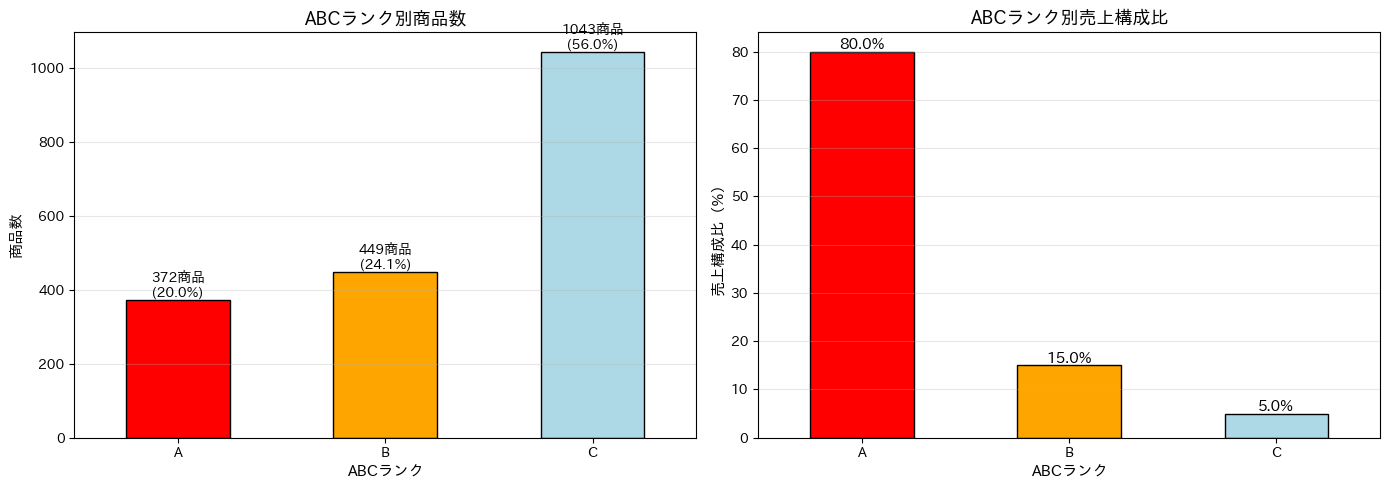

In [7]:
# ABCランク別グラフ
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 商品数の比較
abc_summary['商品数'].plot(kind='bar', ax=axes[0], color=['red', 'orange', 'lightblue'], edgecolor='black')
axes[0].set_title('ABCランク別商品数', fontsize=13, fontproperties=JP_FP)
axes[0].set_xlabel('ABCランク', fontsize=11, fontproperties=JP_FP)
axes[0].set_ylabel('商品数', fontsize=11, fontproperties=JP_FP)
axes[0].set_xticklabels(['A', 'B', 'C'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(abc_summary['商品数']):
    axes[0].text(i, v, f'{int(v, fontproperties=JP_FP)}商品\n({abc_summary["商品数構成比"].iloc[i]:.1f}%)', 
                ha='center', va='bottom', fontsize=10)

# 売上構成比の比較
abc_summary['売上構成比'].plot(kind='bar', ax=axes[1], color=['red', 'orange', 'lightblue'], edgecolor='black')
axes[1].set_title('ABCランク別売上構成比', fontsize=13, fontproperties=JP_FP)
axes[1].set_xlabel('ABCランク', fontsize=11, fontproperties=JP_FP)
axes[1].set_ylabel('売上構成比（%）', fontsize=11, fontproperties=JP_FP)
axes[1].set_xticklabels(['A', 'B', 'C'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(abc_summary['売上構成比']):
    axes[1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=11, fontproperties=JP_FP)

plt.tight_layout()
plt.show()

## 🏷️ 5. カテゴリ別ABC分析

### 業務的な意義
どのカテゴリが重要かを把握し、売場配分・棚割りの優先順位を決める

In [8]:
# 大分類別集計
category_summary = df.groupby('フェイスくくり大分類').agg({
    '売上金額': 'sum',
    '売上数量': 'sum',
    '商品名': lambda x: x.nunique()
}).reset_index()

category_summary.columns = ['カテゴリ', '売上金額', '売上数量', '商品数']
category_summary = category_summary.sort_values('売上金額', ascending=False).reset_index(drop=True)

# 構成比・累積構成比
category_summary['構成比'] = (category_summary['売上金額'] / category_summary['売上金額'].sum() * 100).round(1)
category_summary['累積構成比'] = category_summary['構成比'].cumsum().round(1)
category_summary['ABCランク'] = category_summary['累積構成比'].apply(assign_abc_rank)

print("="*60)
print("🏷️ カテゴリ別ABC分析（大分類）")
print("="*60)
print(category_summary.to_string(index=False))

print("\n" + "-"*60)
print("【業務的な意味】")
a_categories = category_summary[category_summary['ABCランク']=='A']['カテゴリ'].tolist()
print(f"  重点カテゴリ（Aランク）: {', '.join(a_categories)}")
print(f"  → これらのカテゴリの売場・在庫を優先的に確保する")

🏷️ カテゴリ別ABC分析（大分類）
                  カテゴリ   売上金額  売上数量  商品数  構成比  累積構成比 ABCランク
                290:たばこ 17548793.0   34601.0     208    21.1        21.1         A
                  100:米飯 15378721.0   79765.0     145    18.5        39.6         A
            215:ドライ飲料 14804873.0  112038.0     111    17.8        57.4         A
                  145:パン  7513568.0   51756.0     128     9.0        66.4         A
              110:調理パン  4363530.0   13656.0      58     5.2        71.6         A
      180:ガム・キャンディ  4246163.0   24873.0     197     5.1        76.7         A
      135:牛乳・チルド飲料  2113940.0   12854.0      67     2.5        79.2         A
      280:チケット・カード  2113310.0     189.0      15     2.5        81.7         B
      205:健康サポート飲料  1699667.0    8454.0      24     2.0        83.7         B
          240:紙・衛生用品  1353080.0    4891.0      29     1.6        85.3         B
      185:洋風菓子・駄菓子  1328408.0    8155.0     143     1.6        86.9         B
          305:ワイン・洋酒  1259495.0    71

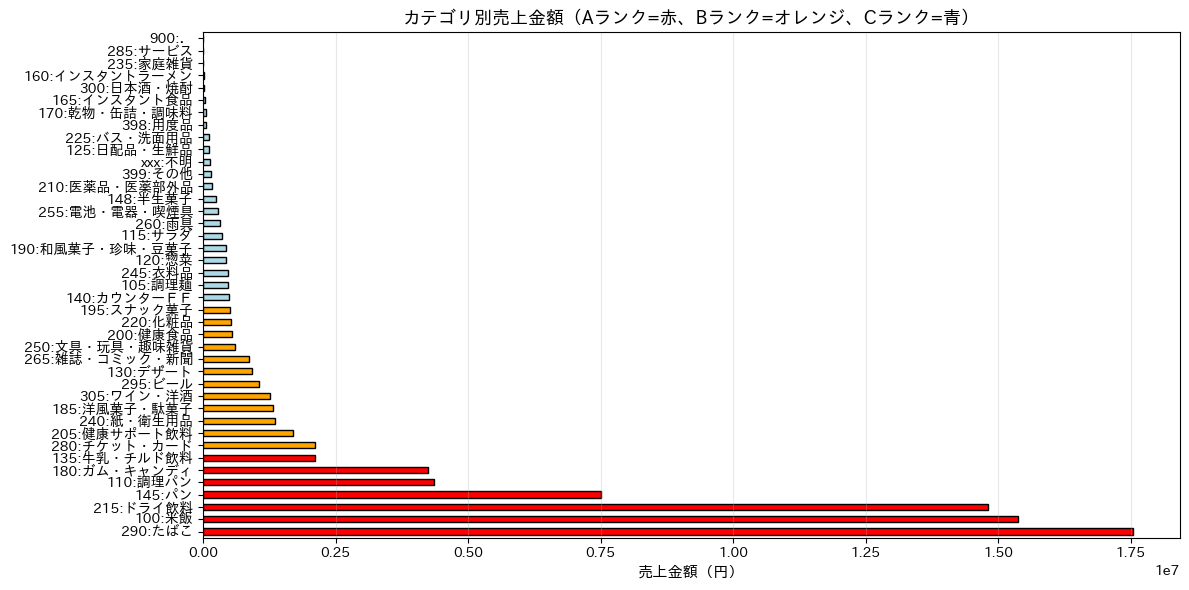

In [9]:
# カテゴリ別売上のグラフ
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['red' if rank=='A' else 'orange' if rank=='B' else 'lightblue' 
          for rank in category_summary['ABCランク']]

category_summary.plot(x='カテゴリ', y='売上金額', kind='barh', ax=ax, 
                      color=colors, edgecolor='black', legend=False)
ax.set_title('カテゴリ別売上金額（Aランク=赤、Bランク=オレンジ、Cランク=青）', 
             fontsize=13, fontproperties=JP_FP)
ax.set_xlabel('売上金額（円）', fontsize=11, fontproperties=JP_FP)
ax.set_ylabel('', fontproperties=JP_FP)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## ⚠️ 6. 死に筋商品の特定

### 死に筋商品の定義
以下のいずれかに該当する商品:
1. **Cランク商品** かつ **1日平均売上が極端に低い**（例: 100円以下）
2. **販売日数が少ない**（例: 全体の20%以下）
3. **売上数量が極端に少ない**（例: 期間中10個以下）

### 業務的な意義
在庫削減・廃番検討の候補商品をリストアップし、キャッシュフローを改善する

In [10]:
# 死に筋商品の定義
total_days = (df['日付'].max() - df['日付'].min()).days + 1

dead_stock = product_summary[
    (product_summary['ABCランク'] == 'C') & 
    (
        (product_summary['1日平均売上'] < 100) | 
        (product_summary['販売日数'] < total_days * 0.2) |
        (product_summary['売上数量'] < 10)
    )
].copy()

dead_stock = dead_stock.sort_values('売上金額', ascending=True)

print("="*60)
print("⚠️ 死に筋商品リスト（在庫削減・廃番検討候補）")
print("="*60)
print(f"\n該当商品数: {len(dead_stock):,}商品")
print(f"売上合計: ¥{dead_stock['売上金額'].sum():,.0f}（全体の{dead_stock['売上金額'].sum()/product_summary['売上金額'].sum()*100:.2f}%）")

print("\n【死に筋商品TOP20（売上金額が低い順）】")
print(dead_stock.head(20)[['商品名', '売上金額', '売上数量', '販売日数', '1日平均売上', 'ABCランク']].to_string(index=False))

print("\n" + "-"*60)
print("【業務的なアクション】")
print("  1. これらの商品の在庫を確認")
print("  2. 発注を停止し、現在の在庫を売り切る")
print("  3. 売り切った後は廃番を検討")
print("  4. 売場スペースを A/B商品に振り分ける")

⚠️ 死に筋商品リスト（在庫削減・廃番検討候補）

該当商品数: 901商品
売上合計: ¥2,916,144（全体の3.51%）

【死に筋商品TOP20（売上金額が低い順）】
                  商品名  売上金額  売上数量  販売日数  1日平均売上 ABCランク
スポーツ報知（関東東北北       0.0       0.0        14          0.0         C
レジ従業員金庫引継ノート       0.0       0.0         1          0.0         C
          備蓄米　２Ｋｇ       0.0       0.0         1          0.0         C
            備蓄米１Ｋｇ       0.0       0.0         1          0.0         C
    優馬（関東山形福島）       0.0       0.0         4          0.0         C
      コーヒーフレッシュ       0.0       0.0         4          0.0         C
東京新聞（１都６県静０１       0.0       0.0        13          0.0         C
東京スポーツ（１都６県静       0.0       0.0         9          0.0         C
      コーヒーリッド黒Ｓ       0.0       0.0         1          0.0         C
  東京スポーツ競馬特別版       0.0       0.0         6          0.0         C
新旧両用）ペーパフィルタ       0.0       0.0         1          0.0         C
    新・値下シール３０円       0.0       0.0         2          0.0         C
    カーセンサー東日本版       0.0       0.0       

## 🚀 7. 機会ロス商品の発見

### 機会ロス商品の定義
以下の条件を満たす商品:
1. **Aランク商品** かつ **1日平均売上が高い**
2. **販売日数が少ない**（欠品している可能性）

### 業務的な意義
もっと売れるはずなのに在庫不足で売り逃している商品を発見し、発注を強化する

In [11]:
# 機会ロス商品の定義
opportunity_loss = product_summary[
    (product_summary['ABCランク'] == 'A') & 
    (product_summary['販売日数'] < total_days * 0.8)  # 80%以下の日しか販売していない
].copy()

opportunity_loss = opportunity_loss.sort_values('1日平均売上', ascending=False)

# 機会ロス金額の推定（もし毎日売れていたら...）
opportunity_loss['潜在売上'] = opportunity_loss['1日平均売上'] * total_days
opportunity_loss['機会ロス金額'] = opportunity_loss['潜在売上'] - opportunity_loss['売上金額']

print("="*60)
print("🚀 機会ロス商品リスト（発注強化候補）")
print("="*60)
print(f"\n該当商品数: {len(opportunity_loss):,}商品")
print(f"推定機会ロス合計: ¥{opportunity_loss['機会ロス金額'].sum():,.0f}")

if len(opportunity_loss) > 0:
    print("\n【機会ロス商品TOP20（1日平均売上が高い順）】")
    print(opportunity_loss.head(20)[['商品名', '売上金額', '1日平均売上', '販売日数', '機会ロス金額', 'ABCランク']].to_string(index=False))
    
    print("\n" + "-"*60)
    print("【業務的なアクション】")
    print("  1. これらの商品が欠品していないか確認")
    print("  2. 発注量を増やす（安全在庫を確保）")
    print("  3. 売場の目立つ位置に配置")
    print(f"  4. 機会ロスを防げば、{opportunity_loss['機会ロス金額'].sum()/1000000:.1f}百万円の追加売上が見込める")
else:
    print("\n✅ A商品の欠品リスクは低いです（すべてのA商品が十分に販売されています）")

🚀 機会ロス商品リスト（発注強化候補）

該当商品数: 166商品
推定機会ロス合計: ¥40,885,978

【機会ロス商品TOP20（1日平均売上が高い順）】
                  商品名  売上金額  1日平均売上  販売日数  機会ロス金額 ABCランク
    楽天ギフトバリアブル  460500.0      51167.0         9     4246864.0         A
  ＡｐｐｌｅＧＣ　ＶＡＲ  299200.0      27200.0        11     2203200.0         A
  ポケカ拡張インフェルノ  102664.0      25666.0         4     2258608.0         A
    い・ろ・は・す５４０ 1190974.0      19850.0        60      635226.0         A
サントリー天然水　５５０  588112.0      15895.0        37      874228.0         A
      ＡｍａｚｏｎＶＡＲ  336100.0      15277.0        22     1069384.0         A
  ＡｐｐｌｅＧＣ＿ＶＡＲ  510600.0      15018.0        34      871056.0         A
    ＧＰｌａｙバリアブル  303010.0      10100.0        30      626190.0         A
  ポケカ拡張メガブレイブ  112996.0       9416.0        12      753276.0         A
      健康ミネラルむぎ茶  668498.0       9415.0        71      197682.0         A
        その他３口座売上  152774.0       8987.0        17      674030.0         A
大きな　鮭マヨと生たらこ  260544.0       8984.0        29      565984.0         A


## 📈 8. カテゴリ×ABCランクのクロス分析

### 業務的な意義
カテゴリごとに重点商品を把握し、カテゴリマネジメントに活用する

In [12]:
# 商品マスタにカテゴリ情報を追加
product_with_category = product_summary.merge(
    df[['商品名', 'フェイスくくり大分類']].drop_duplicates(),
    on='商品名',
    how='left'
)

# カテゴリ×ABCランクのクロス集計
category_abc_cross = product_with_category.groupby(['フェイスくくり大分類', 'ABCランク']).agg({
    '商品名': 'count',
    '売上金額': 'sum'
}).reset_index()

category_abc_cross.columns = ['カテゴリ', 'ABCランク', '商品数', '売上金額']

# ピボットテーブル化
pivot_count = category_abc_cross.pivot(index='カテゴリ', columns='ABCランク', values='商品数').fillna(0).astype(int)
pivot_sales = category_abc_cross.pivot(index='カテゴリ', columns='ABCランク', values='売上金額').fillna(0)

# ランク順にソート
pivot_count = pivot_count[['A', 'B', 'C']]
pivot_sales = pivot_sales[['A', 'B', 'C']]

print("="*60)
print("📈 カテゴリ×ABCランク クロス集計（商品数）")
print("="*60)
print(pivot_count.to_string())

print("\n" + "="*60)
print("📈 カテゴリ×ABCランク クロス集計（売上金額）")
print("="*60)
print(pivot_sales.to_string())

print("\n" + "-"*60)
print("【業務的な意味】")
print("  ✓ Aランク商品が多いカテゴリ → 重点カテゴリ（売場・在庫を優先）")
print("  ✓ Cランク商品が多いカテゴリ → 商品整理が必要")

📈 カテゴリ×ABCランク クロス集計（商品数）
ABCランク                    A   B    C
カテゴリ                               
100:米飯                    60  28   57
105:調理麺                   1   8   60
110:調理パン                19  18   21
115:サラダ                   2   4   20
120:惣菜                     2   7   14
125:日配品・生鮮品           1   1    6
130:デザート                 5   7   74
135:牛乳・チルド飲料        11  18   38
140:カウンターＦＦ           2   2   12
145:パン                    52  50   26
148:半生菓子                 3  14   27
160:インスタントラーメン     0   0    3
165:インスタント食品         0   1    6
170:乾物・缶詰・調味料       0   1    1
180:ガム・キャンディ        22  79   96
185:洋風菓子・駄菓子         3  30  110
190:和風菓子・珍味・豆菓子   0  10   53
195:スナック菓子             2   6   37
200:健康食品                 2  10   15
205:健康サポート飲料         9   4   11
210:医薬品・医薬部外品       1   0    0
215:ドライ飲料              52  27   32
220:化粧品                   3   8   14
225:バス・洗面用品           0   3   11
235:家庭雑貨                 0   0    2
240:紙・衛生用品            11  10    8
245:衣料品       

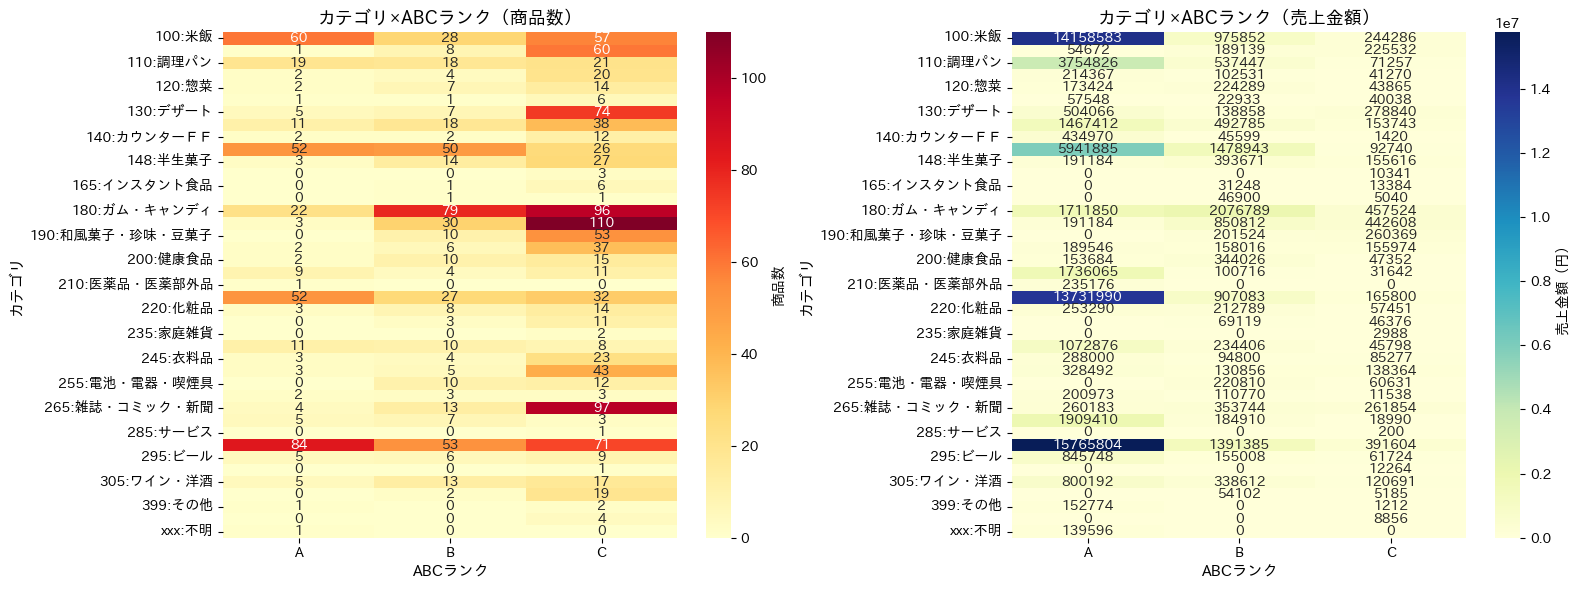

In [13]:
# ヒートマップで可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 商品数
sns.heatmap(pivot_count, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0], cbar_kws={'label': '商品数'})
axes[0].set_title('カテゴリ×ABCランク（商品数）', fontsize=13, fontproperties=JP_FP)
axes[0].set_xlabel('ABCランク', fontsize=11, fontproperties=JP_FP)
axes[0].set_ylabel('カテゴリ', fontsize=11, fontproperties=JP_FP)

# 売上金額
sns.heatmap(pivot_sales, annot=True, fmt='.0f', cmap='YlGnBu', ax=axes[1], cbar_kws={'label': '売上金額（円）'})
axes[1].set_title('カテゴリ×ABCランク（売上金額）', fontsize=13, fontproperties=JP_FP)
axes[1].set_xlabel('ABCランク', fontsize=11, fontproperties=JP_FP)
axes[1].set_ylabel('カテゴリ', fontsize=11, fontproperties=JP_FP)

plt.tight_layout()
plt.show()

## 💾 9. ABC分析結果の保存

### 業務的な活用
- **発注担当**: ABC商品リストを見ながら発注する
- **店長**: 死に筋商品リストを元に在庫削減する
- **オーナー**: 機会ロス商品を確認し、売上拡大のチャンスを掴む

In [14]:
# 出力ディレクトリ
output_dir = Path('output/stage2_abc_analysis')
output_dir.mkdir(parents=True, exist_ok=True)

# 商品別ABC分析結果
product_with_category.to_csv(output_dir / '商品別ABC分析.csv', index=False, encoding='utf-8-sig')

# カテゴリ別ABC分析結果
category_summary.to_csv(output_dir / 'カテゴリ別ABC分析.csv', index=False, encoding='utf-8-sig')

# 死に筋商品リスト
dead_stock.to_csv(output_dir / '死に筋商品リスト.csv', index=False, encoding='utf-8-sig')

# 機会ロス商品リスト
if len(opportunity_loss) > 0:
    opportunity_loss.to_csv(output_dir / '機会ロス商品リスト.csv', index=False, encoding='utf-8-sig')

# カテゴリ×ABCクロス集計
pivot_count.to_csv(output_dir / 'カテゴリ×ABC_商品数.csv', encoding='utf-8-sig')
pivot_sales.to_csv(output_dir / 'カテゴリ×ABC_売上金額.csv', encoding='utf-8-sig')

print("✅ ABC分析結果を保存しました:")
print(f"   {output_dir}/")
print("\n📋 保存ファイル:")
print("  - 商品別ABC分析.csv")
print("  - カテゴリ別ABC分析.csv")
print("  - 死に筋商品リスト.csv")
print("  - 機会ロス商品リスト.csv")
print("  - カテゴリ×ABC_商品数.csv")
print("  - カテゴリ×ABC_売上金額.csv")

✅ ABC分析結果を保存しました:
   output/stage2_abc_analysis/

📋 保存ファイル:
  - 商品別ABC分析.csv
  - カテゴリ別ABC分析.csv
  - 死に筋商品リスト.csv
  - 機会ロス商品リスト.csv
  - カテゴリ×ABC_商品数.csv
  - カテゴリ×ABC_売上金額.csv


## 💡 10. Stage 2 まとめ

### ABC分析で分かったこと
1. **A商品**: 少数の商品が売上の大半を作る → 絶対に欠品させない
2. **C商品**: 多数の商品が売上にほとんど貢献していない → 在庫削減のチャンス
3. **死に筋商品**: 在庫削減・廃番検討の候補
4. **機会ロス商品**: 発注強化で売上を伸ばせる商品

### 次のステップ
- **Stage 3**: 発注最適化（いつ、どれだけ発注すべきか）
- **Stage 4**: 外部要因分析（天気・イベントの影響）
- **Stage 5**: PyCaretで需要予測モデルを構築

---